# Wavefunction, Loss

<IPython.core.display.Javascript object>


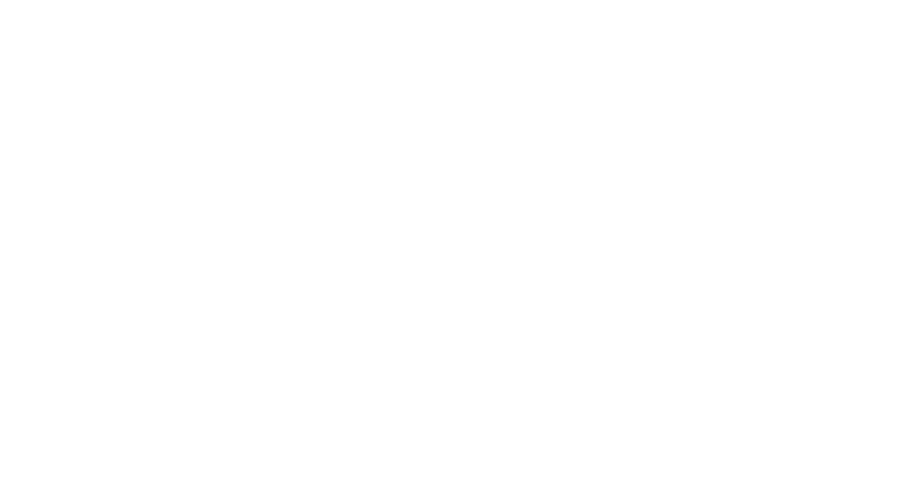

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1161.45it/s]


<IPython.core.display.Javascript object>


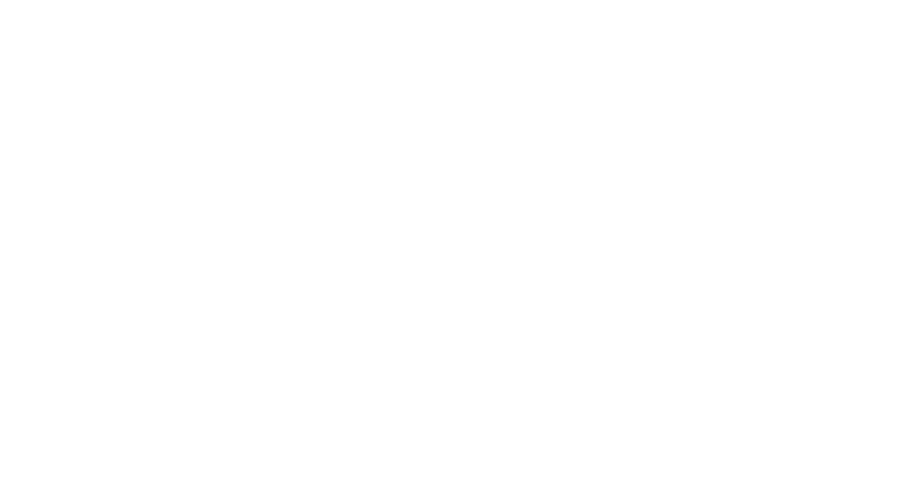

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1058.17it/s]


In [30]:
psi_b1 = []
psi_b2 = []
V_b1 = []
V_b2 = []
target_b1 = []
target_b2 = []
for b in [1.5, 2.1]:
    # Imports
    import torch, time
    from torch import nn, Tensor
    from torch.autograd import grad
    import numpy as np
    import matplotlib.pyplot as plt # Plotting library
    from tqdm import tqdm # Progress bar

    # Hardware (CPU or GPU)
    dev = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(dev)

    # Network hyperparameters
    Nin = 1   # Inputs to the neural network
    Nout = 1  # Outputs of the neural network
    Nhid = 8  # Nodes in the hidden layer

    # Network parameters.
    seed = 1
    torch.manual_seed(seed)
    W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-1.) # First set of coefficients
    B = torch.rand(Nhid, requires_grad=True) * 2. - 1.    # Set of bias parameters
    W2 = torch.rand(Nout, Nhid, requires_grad=True)        # Second set of coefficients

    # Training hyperparameters
    epochs = 3000
    lr = 2e-2  # Learning rate

    # Mesh parameters
    Nx = 100                    # Mesh division
    train_a = -8                     # Mesh lower limit
    train_b = 8                        # Mesh upper limit
    h = (train_b - train_a) / (Nx - 1)  # Mesh parameter "h"
    grid = h*(np.arange(Nx)-Nx/2.+1)
    Q_train = torch.from_numpy(grid).requires_grad_().to(device).type(torch.float32)
    wi = torch.empty(Nx, 1).fill_(h)

    %matplotlib notebook
    # We define useful functions
    l_indices = [l for l in range(-int(Nx/2), int(Nx/2) + 1)]
    V = lambda x : 0.5*(abs(x)-b)**2
    delta = lambda i, j : 1 if i == j else 0
    pi = np.pi
    T = lambda l : 2.*(l*pi/(Nx*h))**2
    zi = complex(0., 1.) # imaginary unit

    # We construct the Hamiltonian matrix elements
    H = np.zeros((Nx, Nx))
    for i, xi in enumerate(grid):
        for j, xj in enumerate(grid):
            list_ = [T(l)*np.exp(zi*l*2.*pi*(i-j)/Nx) for l in l_indices]
            H[i][j] = (1/Nx)*np.real(np.sum(list_)) + V(xi)*delta(i, j)

    # We diagonalize H and obtain the ground-state eigenvalue and eigenvector
    eivals, eivecs = np.linalg.eigh(H)

    # We sort the eigenvalues and eigenvectors
    isort = np.argsort(eivals)
    eivals = eivals[isort]
    eivecs = eivecs[isort]

    ieig = 0
    neig = 4
    indx_origin = int(Nx/2 - 1)
    wf = np.zeros((Nx, neig))

    # We order the wavefunction values by setting the correct origin
    while ieig < neig :
        # wavefunction at the origin
        wf_at_origin = eivecs[indx_origin,ieig]
        sss = eivecs[indx_origin+2,ieig]
        sss = sss/np.abs(sss)
        wf[:,ieig] = sss*eivecs[:,ieig]/np.sqrt(h);
        ieig = ieig+1

    E0_th, psi0_th = eivals[0], wf[:,0]/np.sqrt(h*np.sum(wf[:,0]**2))
    E1_th, psi1_th = eivals[1], wf[:,1]/np.sqrt(h*np.sum(wf[:,1]**2))

    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
    for i in range(neig):
        ax.plot(grid, wf[:, i], label=f'$\psi_{i}$, E=' + format(eivals[i], '.4f'))
    ax.legend()
    fig.canvas.draw()
    time.sleep(0.01)
    """
    
    class HarmonicNQS(nn.Module):
        def __init__(self, W1, B, W2):
            super(HarmonicNQS, self).__init__()

            # We set the operators 
            self.lc1 = nn.Linear(in_features=Nin, 
                                 out_features=Nhid, 
                                 bias=True)   # shape = (Nhid, Nin)
            self.actfun = nn.Sigmoid()        # activation function
            self.lc2 = nn.Linear(in_features=Nhid, 
                                 out_features=Nout, 
                                 bias=False)  # shape = (Nout, Nhid)

            # We set the parameters 
            with torch.no_grad():
                self.lc1.weight = nn.Parameter(W1)
                self.lc1.bias = nn.Parameter(B)
                self.lc2.weight = nn.Parameter(W2)

        # We set the architecture
        def forward(self, x): 
            o = self.lc2(self.actfun(self.lc1(x)))
            return o

    net = HarmonicNQS(W1, B, W2).to(device)
    #print("NN architecture:\n", net)

    optimizer = torch.optim.RMSprop(params=net.parameters(), lr=lr)
    
    def pic(i, x, psi_b1, psi_b2, V_b1, V_b2, target_b1, target_b2, ax1, ax3):  
        
        # First b
        ax1.set_title('NQS wave function, b=1.5', fontsize=15)
        wf = psi_b1.detach().numpy()
        maxwf = np.max(wf)
        if maxwf < 0: wf = -wf
        if ax1.lines:
            # This will run every time the function is called except the first one
            ax1.lines[0].set_xdata(x.detach().numpy())
            ax1.lines[0].set_ydata(wf)
            ax1.lines[1].set_xdata(x.detach().numpy())
            ax1.lines[1].set_ydata(target_b1)
            ax1.lines[2].set_xdata(np.linspace(train_a, train_b, 500))
            ax1.lines[2].set_ydata(V_b1)
        else:
            # This code will only run the first time the function is called
            ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NQS}$', color='b')
            ax1.plot(x.detach().numpy(), target_b1, linestyle="--", 
                     label='$\psi_\mathrm{target}$', color='r')
            ax1.plot(np.linspace(train_a, train_b, 500), V_b1, linestyle='-.',
                     label='$V(x)$', color='g')
            ax1.legend(loc='upper right', fontsize=14)

        # Second b
        ax3.set_title('NQS wave function, b=2.1', fontsize=15)
        wf = psi_b2.detach().numpy()
        maxwf = np.max(wf)
        if maxwf < 0: wf = -wf
        if ax3.lines:
            # This will run every time the function is called except the first one
            ax3.lines[0].set_xdata(x.detach().numpy())
            ax3.lines[0].set_ydata(wf)
            ax3.lines[1].set_xdata(x.detach().numpy())
            ax3.lines[1].set_ydata(target_b2)
            ax3.lines[2].set_xdata(np.linspace(train_a, train_b, 500))
            ax3.lines[2].set_ydata(V_b2)
        else:
            # This code will only run the first time the function is called
            ax3.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NQS}$', color='b')
            ax3.plot(x.detach().numpy(), target_b2, linestyle="--", 
                     label='$\psi_\mathrm{target}$', color='r')
            ax3.plot(np.linspace(train_a, train_b, 500), V_b2, linestyle='-.',
                     label='$V(x)$', color='g')
            ax3.legend(loc='upper right', fontsize=14)

        fig.canvas.draw()

    def loss_fn():  
        psi = net(X)
        psi2 = net(X_det).pow(2)
        dpsi_dx, = grad(outputs=psi, 
                        inputs=X,
                        grad_outputs=torch.ones_like(psi), 
                        create_graph=True)            

        N = torch.tensordot(psi2, wi)                       
        U =  (1/2) * torch.tensordot((torch.abs(X_det)-b).pow(2) * psi2, wi) / N # Potential energy
        K = (1/2) * torch.tensordot(dpsi_dx.pow(2), wi) / N # Kinetic energy
        E = U + K # Total energy

        return E, U, K, psi, psi / torch.sqrt(N) 
    
    # Plotting
    %matplotlib notebook
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
    ax1, ax3 = ax[0], ax[1]
    plt.subplots_adjust(wspace=0.3)

    # Overlap
    ax1.set_xlim(-8.1, 8)
    ax1.set_ylim(-0.02, 1.6)
    ax1.set_xlabel("$x$", fontsize=15)
    ax1.set_ylabel("$\psi(x)$", fontsize=15)
    ax1.set_xticks(np.arange(-8, 8.01, step=4))
    ax1.tick_params(axis='both', labelsize=15)
    ax1.tick_params(axis='both', which='both', direction='in')
    ax1.tick_params(axis='both', which='major', width=1.7, length=4.5)

    # Loss
    ax3.set_xlabel("$x$", fontsize=15)
    ax3.tick_params(axis='both', labelsize=15)
    ax3.tick_params(axis='both', which='both', direction='in')
    ax3.tick_params(axis='both', which='major', width=1.7, length=4.5)
    ax3.set_xlim(-8.1, 8)
    ax3.set_ylim(-0.02, 1.6)

    X = Q_train.clone().unsqueeze(1)
    X_det = X.clone().detach()
    target = psi0_th
    potential = lambda x : 0.5*(np.abs(x)-b)**2
    potential = potential(np.linspace(train_a, train_b, 500))
    
    loss_accum = []
    U_accum = []
    K_accum = []

    # Training
    for i in tqdm(range(epochs), desc="Training the NQS..."):
        loss0, U, K, psi, psi_normalized = loss_fn()    # Energy and \psi calculation

        optimizer.zero_grad() # initialize gradients to zero at each epoch
        loss0.backward()       # computation of the gradients
        optimizer.step()      # update of the parameters

        loss_accum.append(loss0.item())
        U_accum.append(U.item())
        K_accum.append(K.item())

        if (i == epochs - 1) : # We plot periodically
            if b == 1.5:
                psi_b1 = psi_normalized.clone().detach()
                V_b1 = potential
                target_b1 = target
            elif b == 2.1:
                psi_b2 = psi_normalized.clone().detach()
                V_b2 = potential
                target_b2 = target
                pic(i, Q_train, psi_b1, psi_b2, V_b1, V_b2, target_b1, target_b2, ax1, ax3)
                time.sleep(0.01)
                plt.savefig('DW_training.pdf', format='pdf', bbox_inches='tight')

# E vs. b

<IPython.core.display.Javascript object>


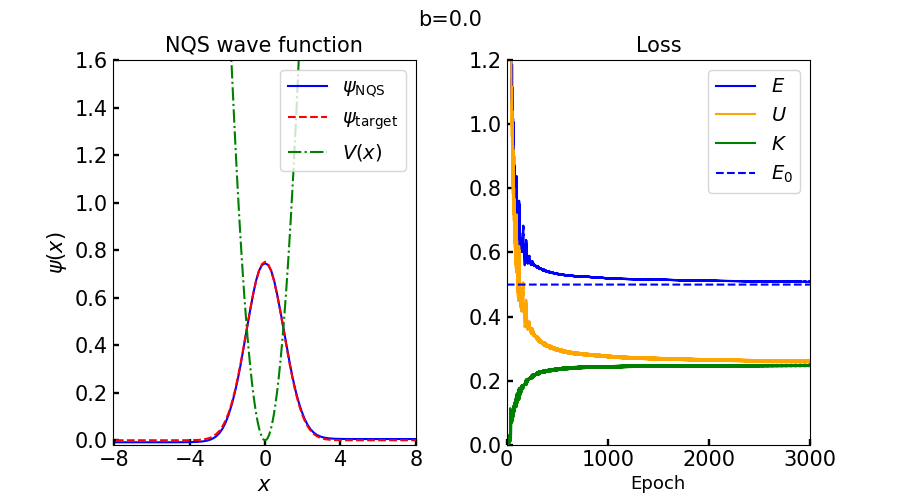

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1107.27it/s]


<IPython.core.display.Javascript object>


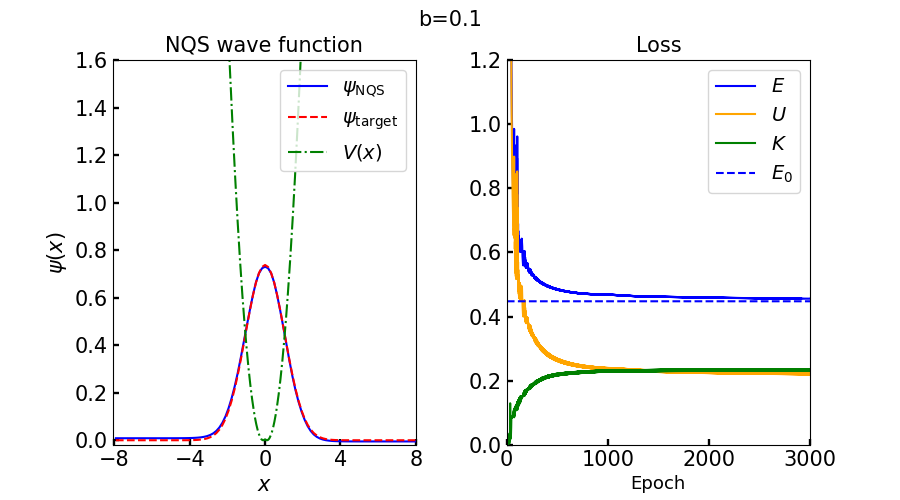

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1112.69it/s]


<IPython.core.display.Javascript object>


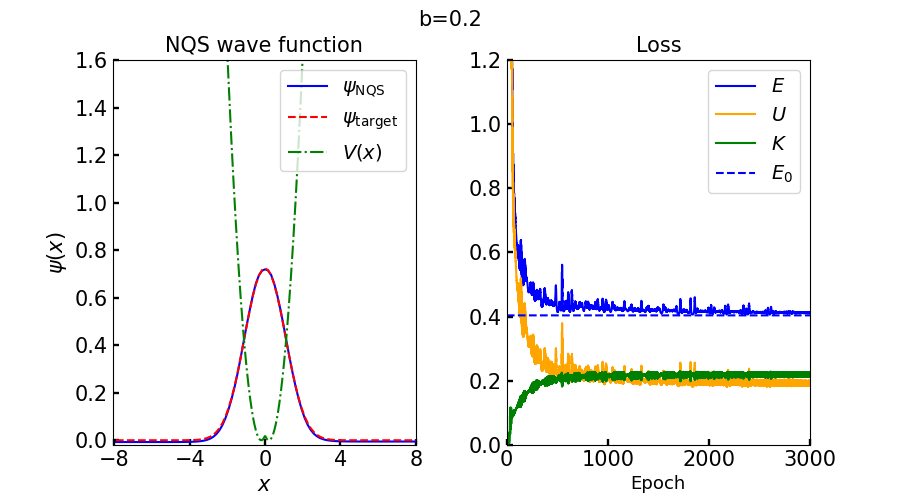

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1108.86it/s]


<IPython.core.display.Javascript object>


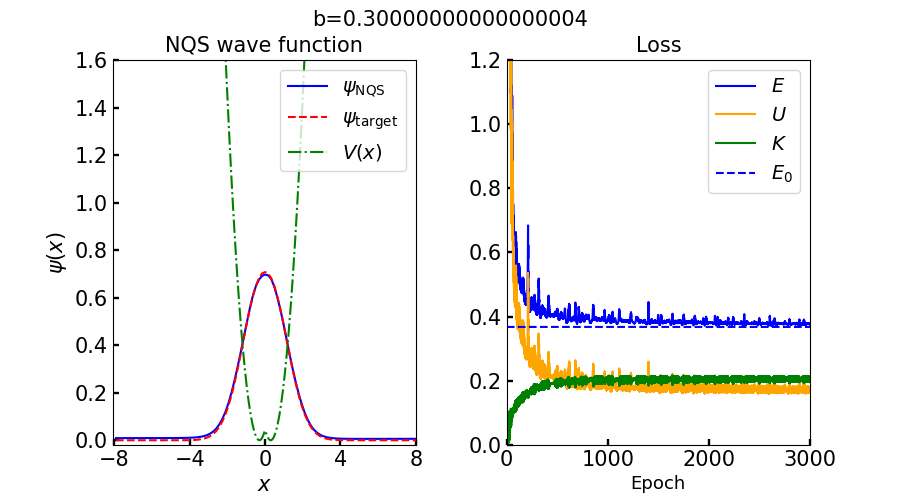

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1109.04it/s]


<IPython.core.display.Javascript object>


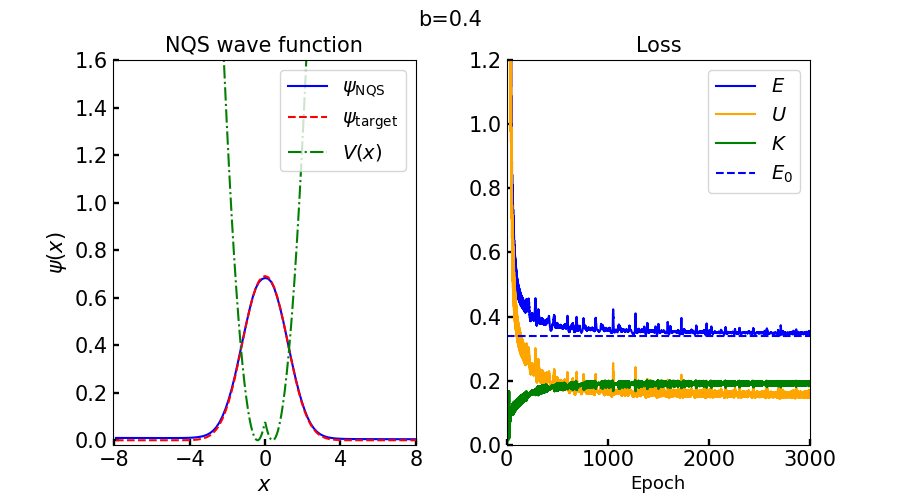

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1105.04it/s]


<IPython.core.display.Javascript object>


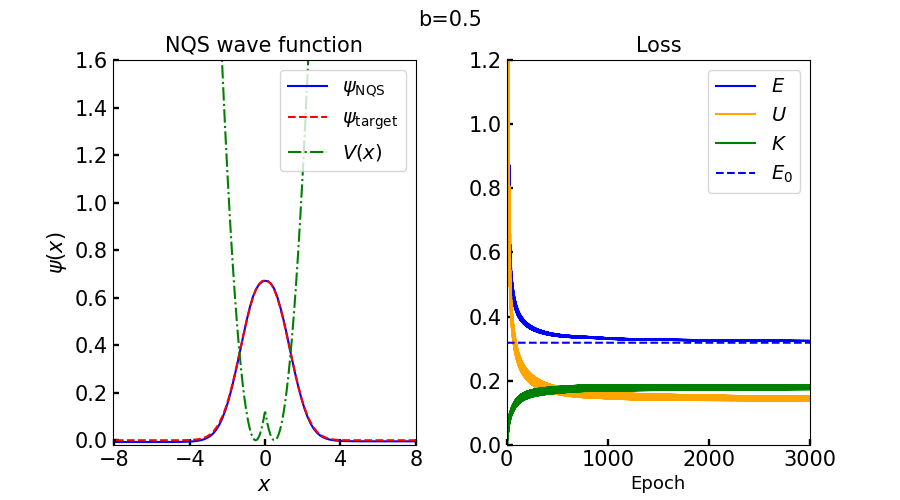

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1096.47it/s]


<IPython.core.display.Javascript object>


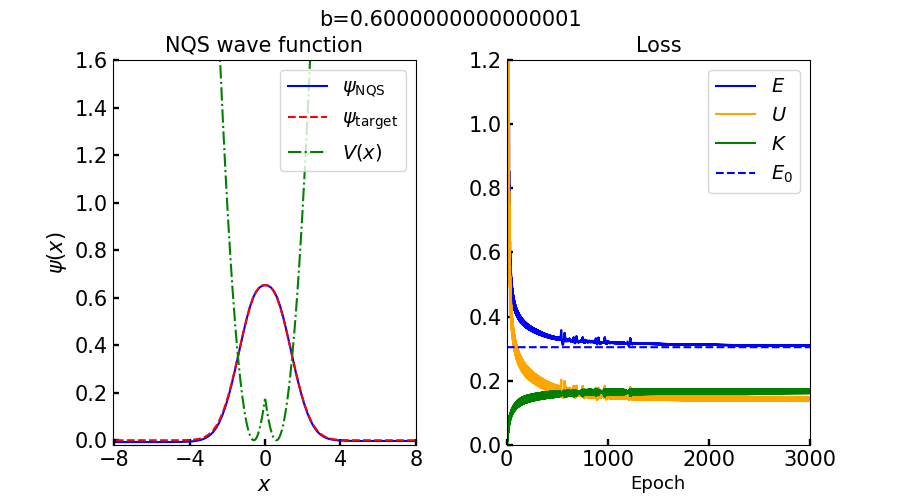

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1101.05it/s]


<IPython.core.display.Javascript object>


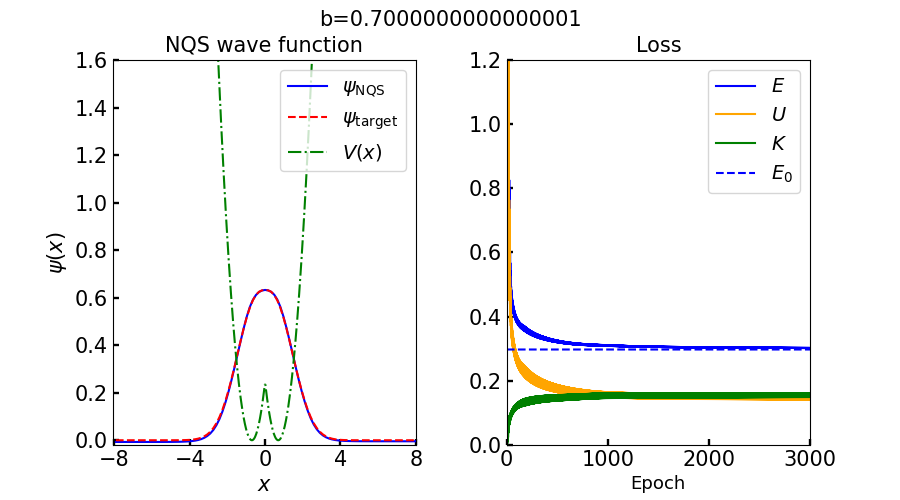

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1107.70it/s]


<IPython.core.display.Javascript object>


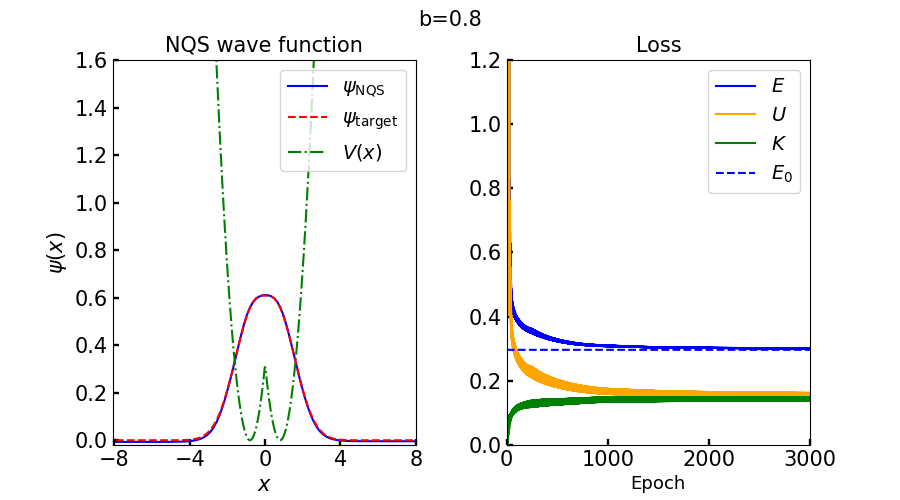

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1085.11it/s]


<IPython.core.display.Javascript object>


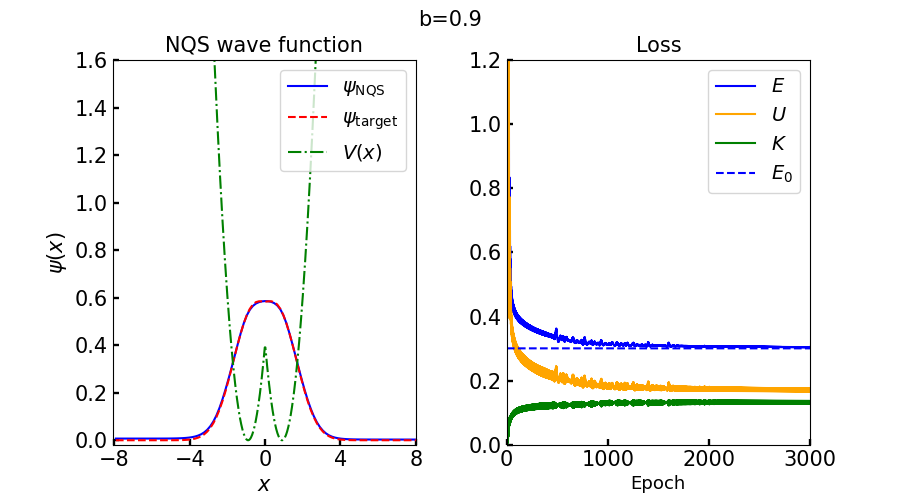

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1087.14it/s]


<IPython.core.display.Javascript object>


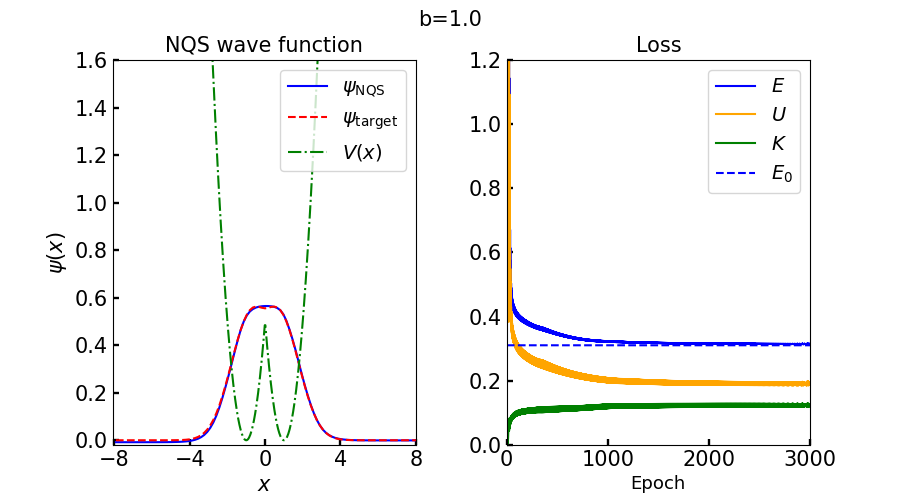

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1129.98it/s]


<IPython.core.display.Javascript object>


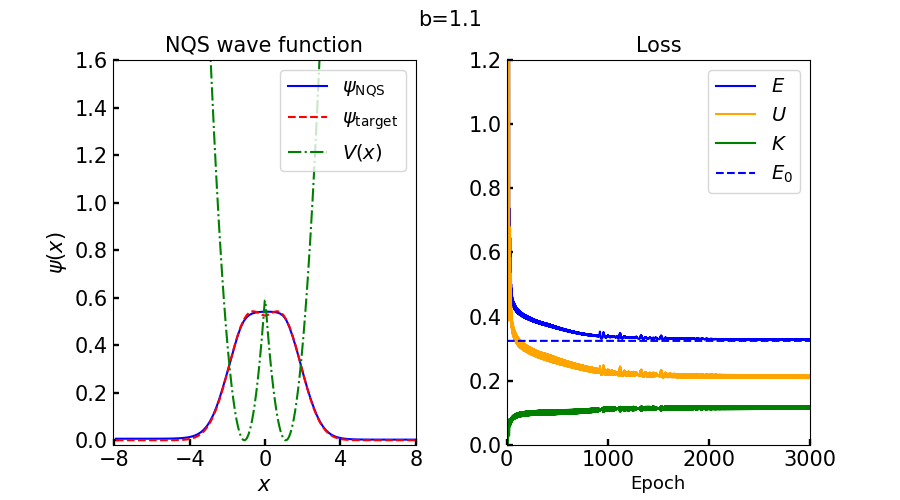

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1120.70it/s]


<IPython.core.display.Javascript object>


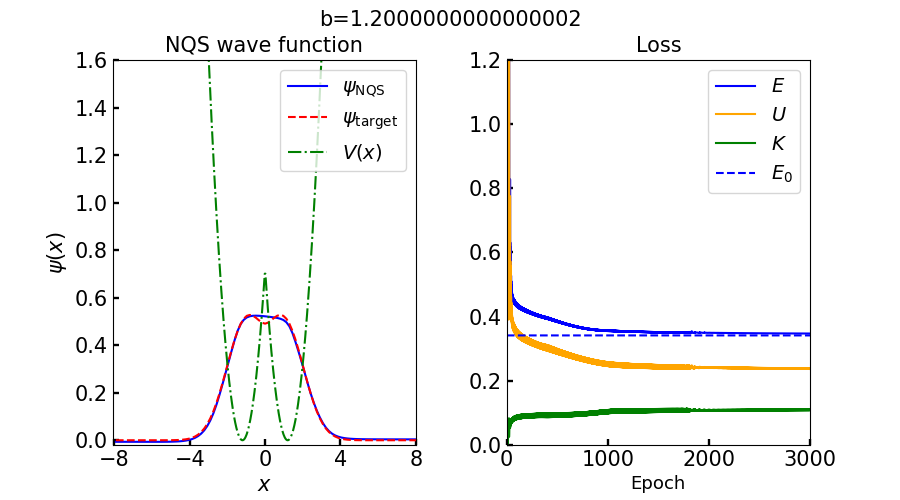

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1109.86it/s]


<IPython.core.display.Javascript object>


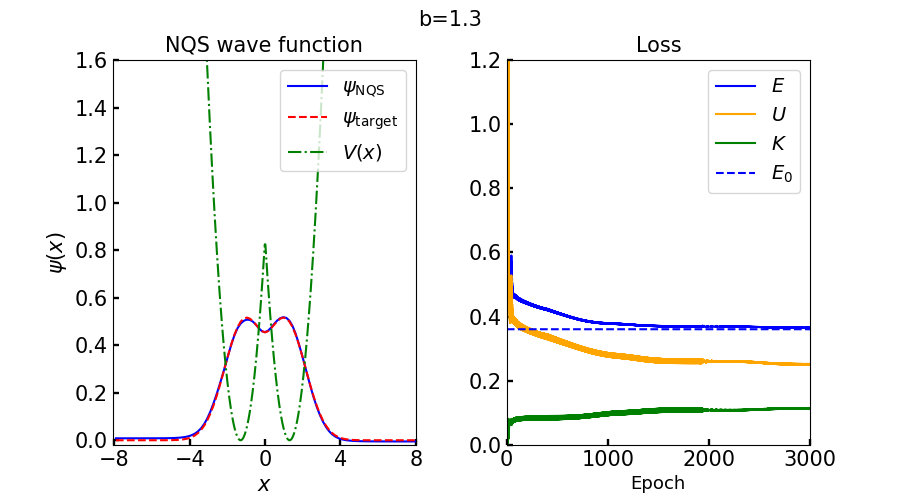

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1125.15it/s]


<IPython.core.display.Javascript object>


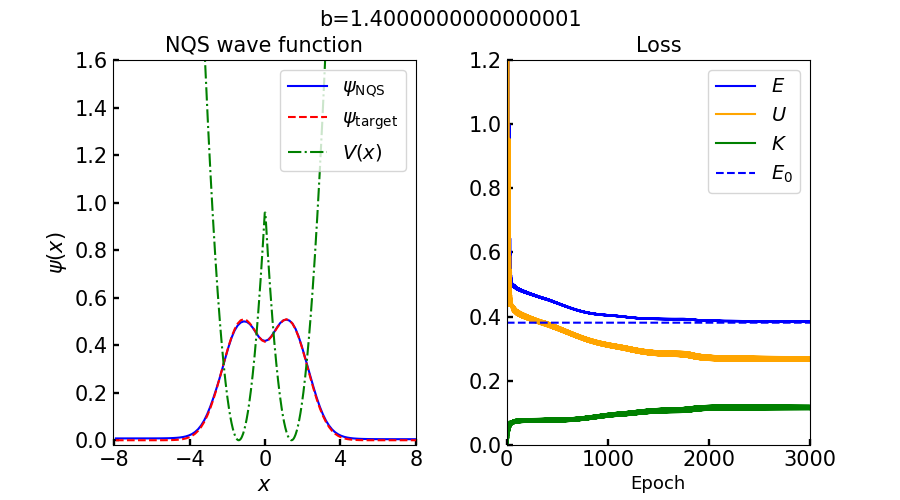

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1100.57it/s]


<IPython.core.display.Javascript object>


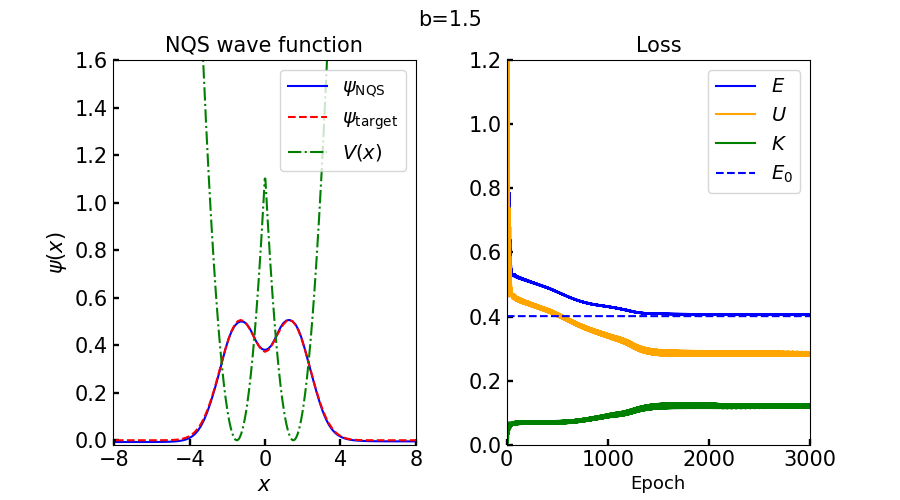

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1094.13it/s]


<IPython.core.display.Javascript object>


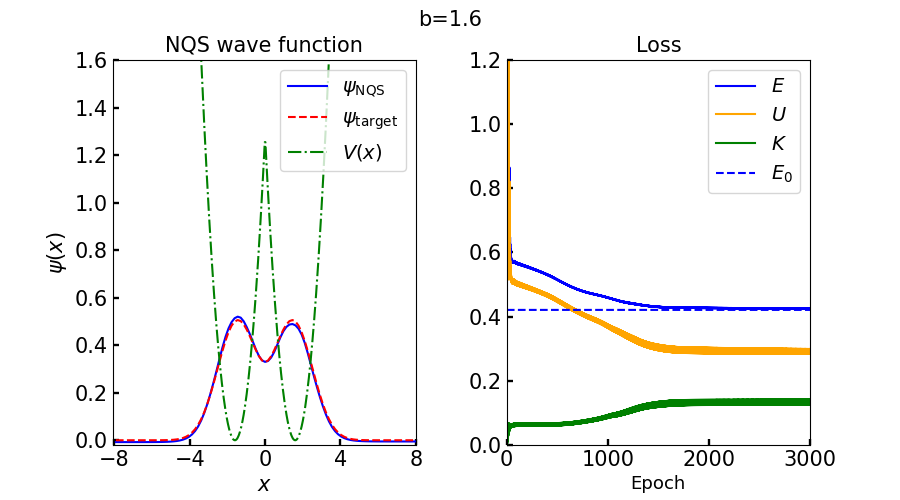

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1112.05it/s]


<IPython.core.display.Javascript object>


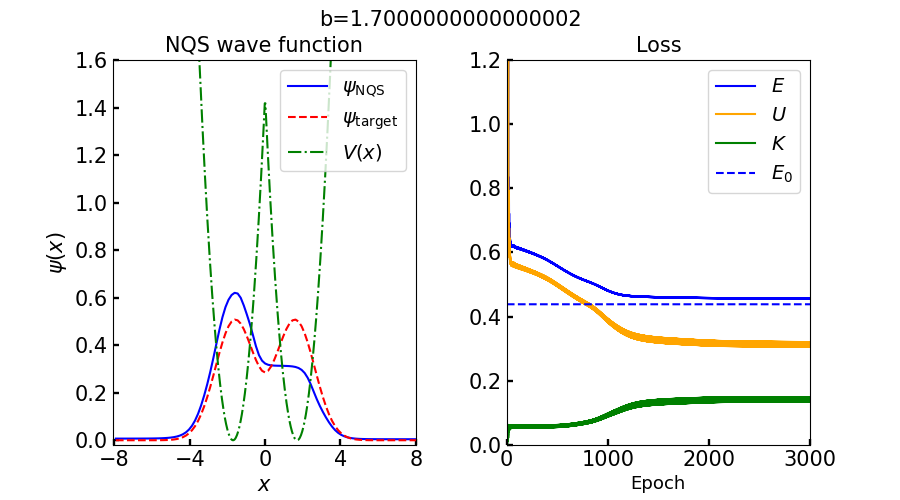

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1095.36it/s]


<IPython.core.display.Javascript object>


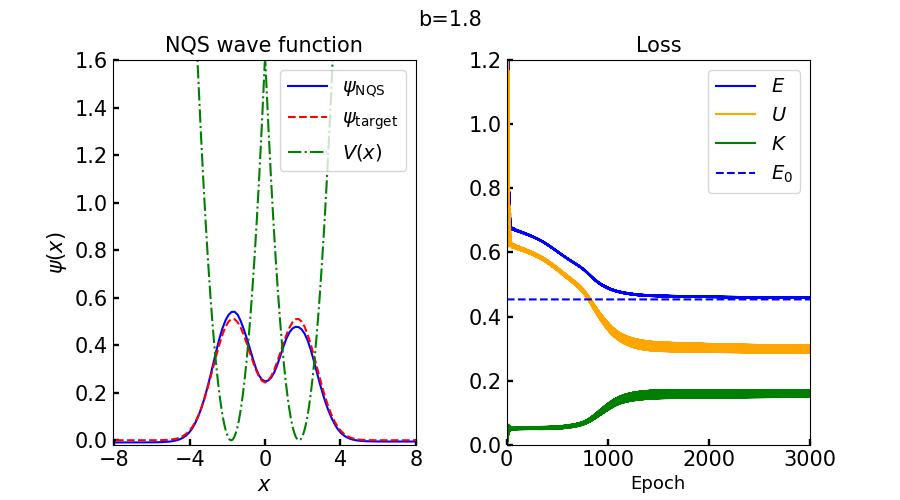

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1134.19it/s]


<IPython.core.display.Javascript object>


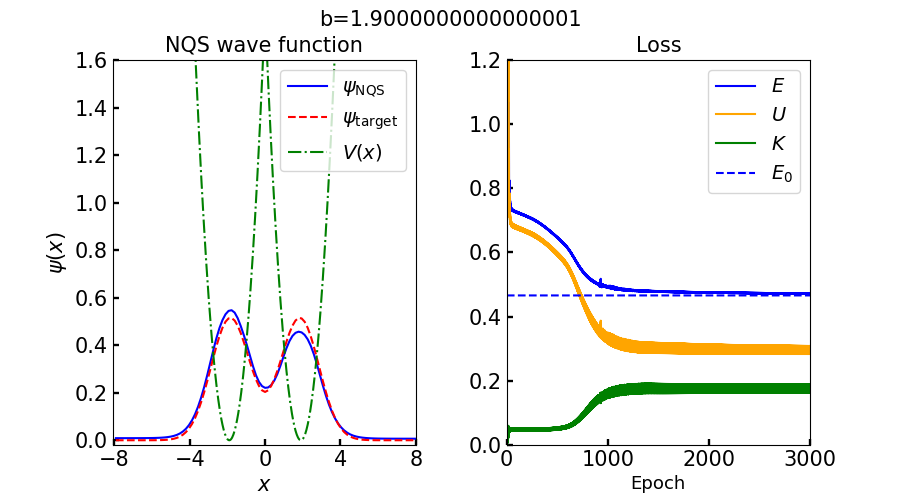

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1130.44it/s]


<IPython.core.display.Javascript object>


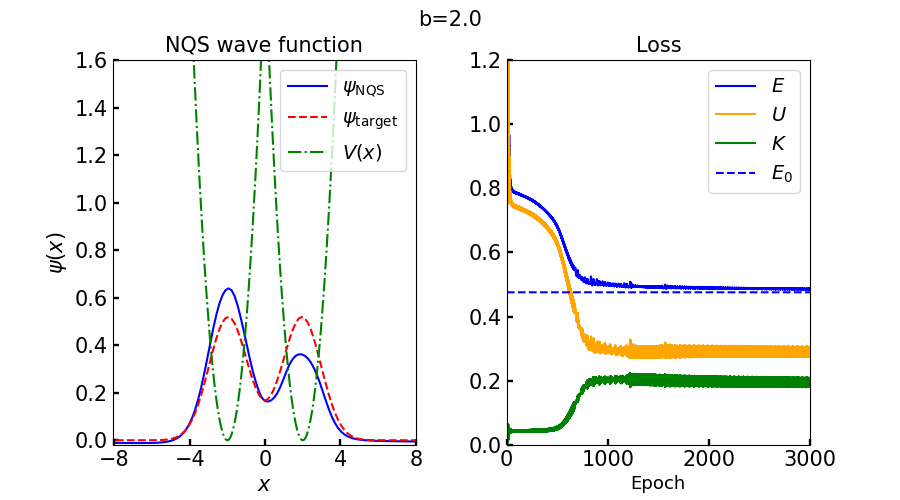

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1129.35it/s]


<IPython.core.display.Javascript object>


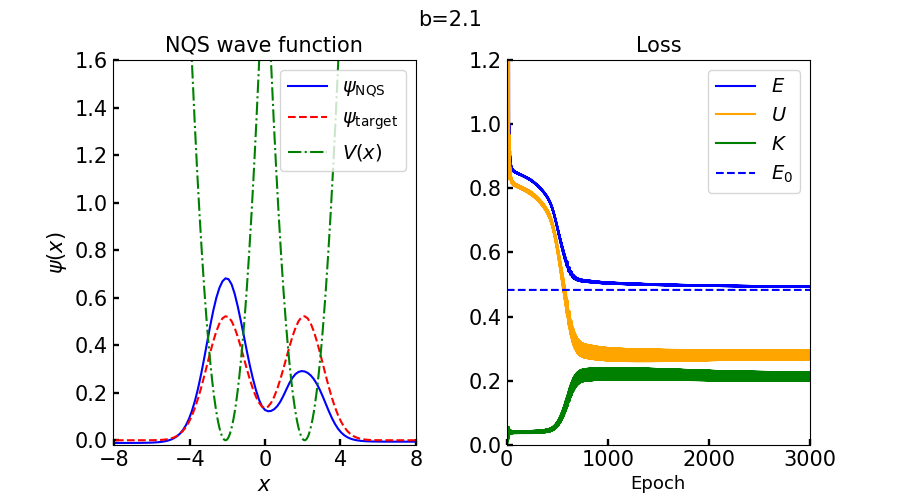

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1123.47it/s]


<IPython.core.display.Javascript object>


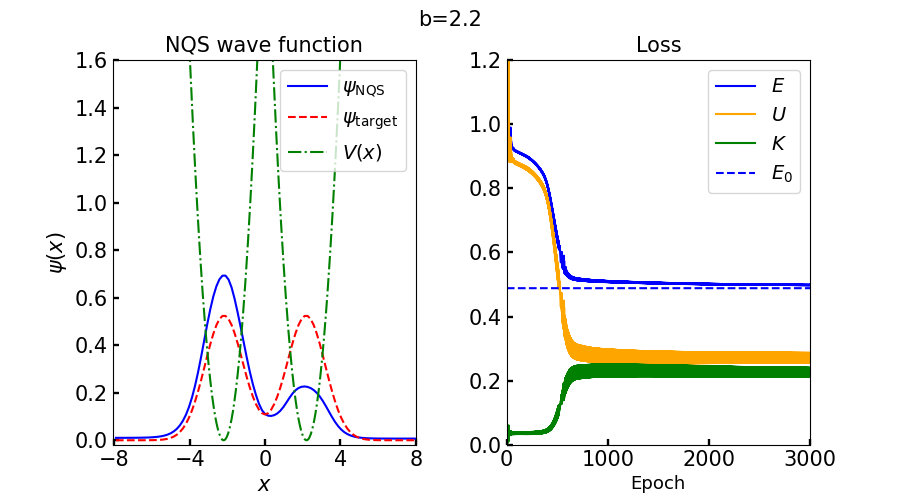

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1110.20it/s]


<IPython.core.display.Javascript object>


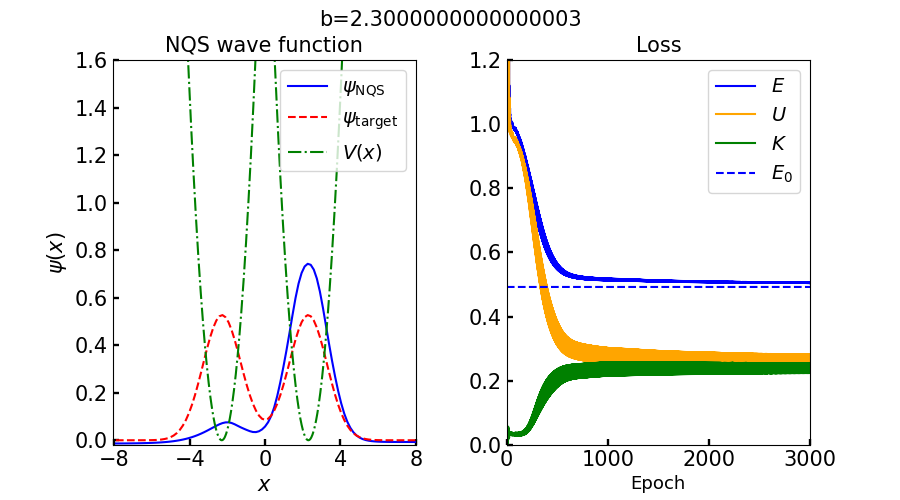

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1108.73it/s]


<IPython.core.display.Javascript object>


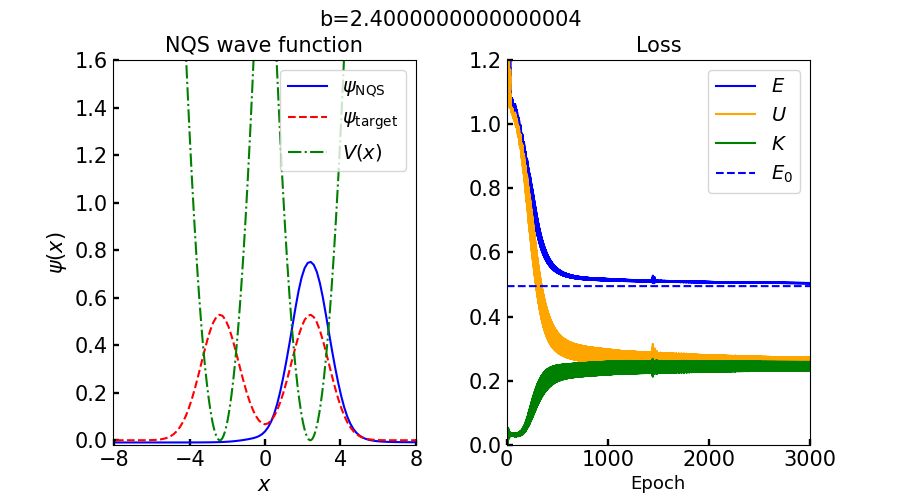

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1129.84it/s]


<IPython.core.display.Javascript object>


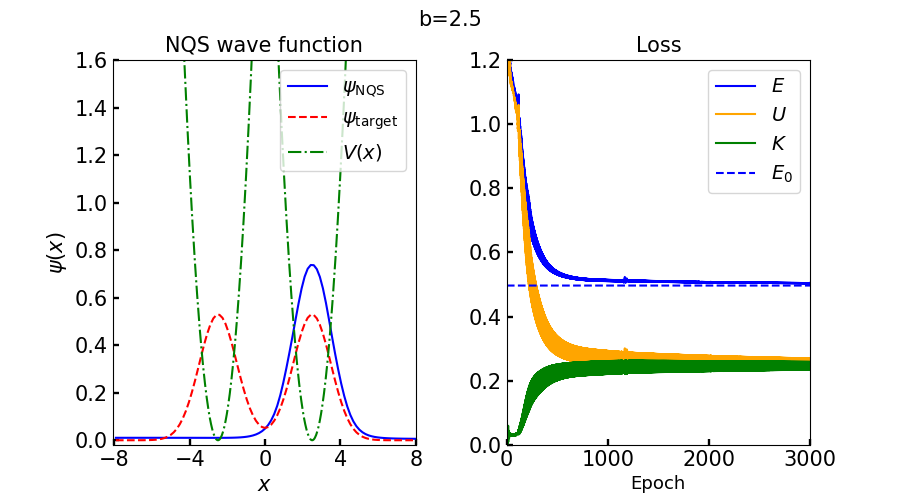

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1117.49it/s]


<IPython.core.display.Javascript object>


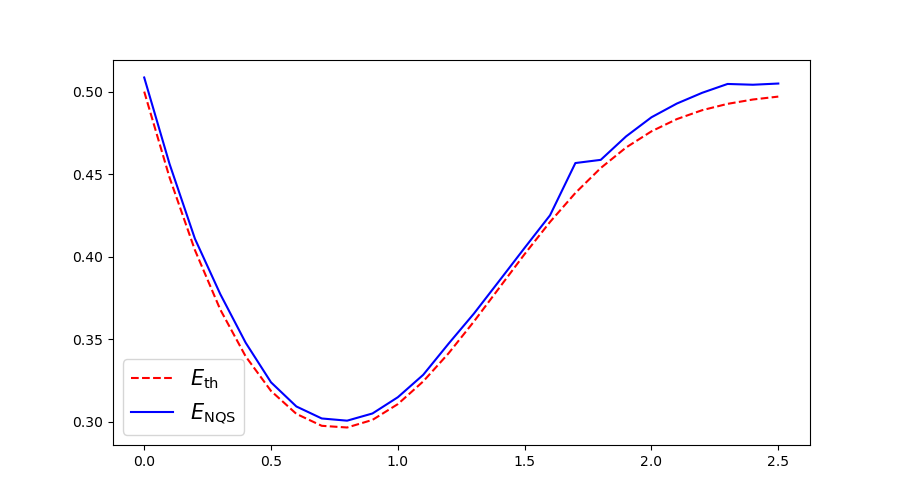

In [18]:
# Imports
import torch, time
from torch import nn, Tensor
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt # Plotting library
from tqdm import tqdm # Progress bar

# Hardware (CPU or GPU)
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)

E_th = []
E_NQS = []
x_axis = np.arange(0, 2.6, step=0.1)
for b in x_axis:
    # Network hyperparameters
    Nin = 1   # Inputs to the neural network
    Nout = 1  # Outputs of the neural network
    Nhid = 8  # Nodes in the hidden layer

    # Network parameters.
    seed = 1
    torch.manual_seed(seed)
    W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-1.) # First set of coefficients
    B = torch.rand(Nhid, requires_grad=True) * 2. - 1.    # Set of bias parameters
    W2 = torch.rand(Nout, Nhid, requires_grad=True)        # Second set of coefficients

    # Training hyperparameters
    epochs = 3000
    lr = 2e-2  # Learning rate

    # Mesh parameters
    Nx = 100                    # Mesh division
    train_a = -8                     # Mesh lower limit
    train_b = 8                        # Mesh upper limit
    h = (train_b - train_a) / (Nx - 1)  # Mesh parameter "h"
    grid = h*(np.arange(Nx)-Nx/2.+1)
    Q_train = torch.from_numpy(grid).requires_grad_().to(device).type(torch.float32)
    wi = torch.empty(Nx, 1).fill_(h)

    %matplotlib notebook
    # We define useful functions
    l_indices = [l for l in range(-int(Nx/2), int(Nx/2) + 1)]
    V = lambda x : 0.5*(abs(x)-b)**2
    delta = lambda i, j : 1 if i == j else 0
    pi = np.pi
    T = lambda l : 2.*(l*pi/(Nx*h))**2
    zi = complex(0., 1.) # imaginary unit

    # We construct the Hamiltonian matrix elements
    H = np.zeros((Nx, Nx))
    for i, xi in enumerate(grid):
        for j, xj in enumerate(grid):
            list_ = [T(l)*np.exp(zi*l*2.*pi*(i-j)/Nx) for l in l_indices]
            H[i][j] = (1/Nx)*np.real(np.sum(list_)) + V(xi)*delta(i, j)

    # We diagonalize H and obtain the ground-state eigenvalue and eigenvector
    eivals, eivecs = np.linalg.eigh(H)

    # We sort the eigenvalues and eigenvectors
    isort = np.argsort(eivals)
    eivals = eivals[isort]
    eivecs = eivecs[isort]

    ieig = 0
    neig = 4
    indx_origin = int(Nx/2 - 1)
    wf = np.zeros((Nx, neig))

    # We order the wavefunction values by setting the correct origin
    while ieig < neig :
        # wavefunction at the origin
        wf_at_origin = eivecs[indx_origin,ieig]
        sss = eivecs[indx_origin+2,ieig]
        sss = sss/np.abs(sss)
        wf[:,ieig] = sss*eivecs[:,ieig]/np.sqrt(h);
        ieig = ieig+1
    
    E0_th, psi0_th = eivals[0], wf[:,0]/np.sqrt(h*np.sum(wf[:,0]**2))
    E_th.append(E0_th)

    class HarmonicNQS(nn.Module):
        def __init__(self, W1, B, W2):
            super(HarmonicNQS, self).__init__()

            # We set the operators 
            self.lc1 = nn.Linear(in_features=Nin, 
                                 out_features=Nhid, 
                                 bias=True)   # shape = (Nhid, Nin)
            self.actfun = nn.Sigmoid()        # activation function
            self.lc2 = nn.Linear(in_features=Nhid, 
                                 out_features=Nout, 
                                 bias=False)  # shape = (Nout, Nhid)

            # We set the parameters 
            with torch.no_grad():
                self.lc1.weight = nn.Parameter(W1)
                self.lc1.bias = nn.Parameter(B)
                self.lc2.weight = nn.Parameter(W2)

        # We set the architecture
        def forward(self, x): 
            o = self.lc2(self.actfun(self.lc1(x)))
            return o

    net = HarmonicNQS(W1, B, W2).to(device)
    optimizer = torch.optim.RMSprop(params=net.parameters(), lr=lr)

    def loss_fn():  
        psi = net(X)
        psi2 = net(X_det).pow(2)
        dpsi_dx, = grad(outputs=psi, 
                        inputs=X,
                        grad_outputs=torch.ones_like(psi), 
                        create_graph=True)            

        N = torch.tensordot(psi2, wi)                       
        U =  (1/2) * torch.tensordot((torch.abs(X_det)-b).pow(2) * psi2, wi) / N # Potential energy
        K = (1/2) * torch.tensordot(dpsi_dx.pow(2), wi) / N # Kinetic energy
        E = U + K # Total energy

        return E, U, K, psi, psi / torch.sqrt(N) 

    def pic(i, x, target, psi, psi_normalized, loss, U, K, ax1, ax3):   

        # Overlap
        ax1.set_title('NQS wave function', fontsize=15)
        wf = psi_normalized.detach().numpy()
        maxwf = np.max(wf)
        if wf[int(Nx/2)] < 0: wf *= -1.
        if ax1.lines:
            # This will run every time the function is called except the first one
            ax1.lines[0].set_xdata(x.detach().numpy())
            ax1.lines[0].set_ydata(wf)
            ax1.lines[1].set_xdata(x.detach().numpy())
            ax1.lines[1].set_ydata(target)
            ax1.lines[2].set_xdata(np.linspace(train_a, train_b, 500))
            ax1.lines[2].set_ydata(potential)
        else:
            # This code will only run the first time the function is called
            ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NQS}$', color='b')
            ax1.plot(x.detach().numpy(), target, linestyle="--", 
                     label='$\psi_\mathrm{target}$', color='r')
            ax1.plot(np.linspace(train_a, train_b, 500), potential, linestyle='-.',
                     label='$V(x)$', color='g')
            ax1.legend(loc='upper right', fontsize=14)

        # Loss
        ax3.set_title("Loss", fontsize=15)
        ax3.set_xlim(0, i+1)
        x = np.linspace(1, i+1, i+1)
        if ax3.lines:
            for line in ax3.lines:
                line.set_xdata(x)
                y = [loss, U, K, np.full(i+1, eivals[0])][ax3.lines.index(line)]
                line.set_ydata(y)
        else:
            ax3.plot(x, loss, label='$E$', color='b')
            ax3.plot(x, U, label='$U$', color='orange')
            ax3.plot(x, K, label='$K$', color='g')
            ax3.plot(x, np.full(i+1, eivals[0]), linestyle='--', label='$E_0$', color='b')
            #ax3.plot(x, np.full(i+1, eivals[0]), linestyle='--', label='$U_0, K_0$', color='g')
            ax3.legend(fontsize=14)

        fig.canvas.draw()

    # Plotting
    %matplotlib notebook
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
    ax1, ax3 = ax[0], ax[1]
    plt.subplots_adjust(wspace=0.3)
    plt.suptitle(f'b={b}', fontsize=15)

    # Overlap
    ax1.set_xlim(-8.1, 8)
    ax1.set_ylim(-0.02, 1.6)
    ax1.set_xlabel("$x$", fontsize=15)
    ax1.set_ylabel("$\psi(x)$", fontsize=15)
    ax1.set_xticks(np.arange(-8, 8.01, step=4))
    ax1.tick_params(axis='both', labelsize=15)
    ax1.tick_params(axis='both', which='both', direction='in')
    ax1.tick_params(axis='both', which='major', width=1.7, length=4.5)

    # Loss
    ax3.set_xlabel("Epoch", fontsize=13)
    ax3.tick_params(axis='both', labelsize=15)
    ax3.tick_params(axis='both', which='both', direction='in')
    ax3.tick_params(axis='both', which='major', width=1.7, length=4.5)
    ax3.set_ylim(0, 1.2)

    loss_accum = []
    U_accum = []
    K_accum = []

    X = Q_train.clone().unsqueeze(1)
    X_det = X.clone().detach()
    target = psi0_th
    potential = lambda x : 0.5*(np.abs(x)-b)**2
    potential = potential(np.linspace(train_a, train_b, 500))

    # Training
    for i in tqdm(range(epochs), desc="Training the NQS..."):
        loss0, U, K, psi, psi_normalized = loss_fn()    # Energy and \psi calculation

        optimizer.zero_grad() # initialize gradients to zero at each epoch
        loss0.backward()       # computation of the gradients
        optimizer.step()      # update of the parameters

        loss_accum.append(loss0.item())
        U_accum.append(U.item())
        K_accum.append(K.item())

        if (i == epochs - 1): # We plot periodically
            pic(i, Q_train, target, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax3)
            time.sleep(0.1)

    E_NQS.append(loss_accum[-1])

<IPython.core.display.Javascript object>


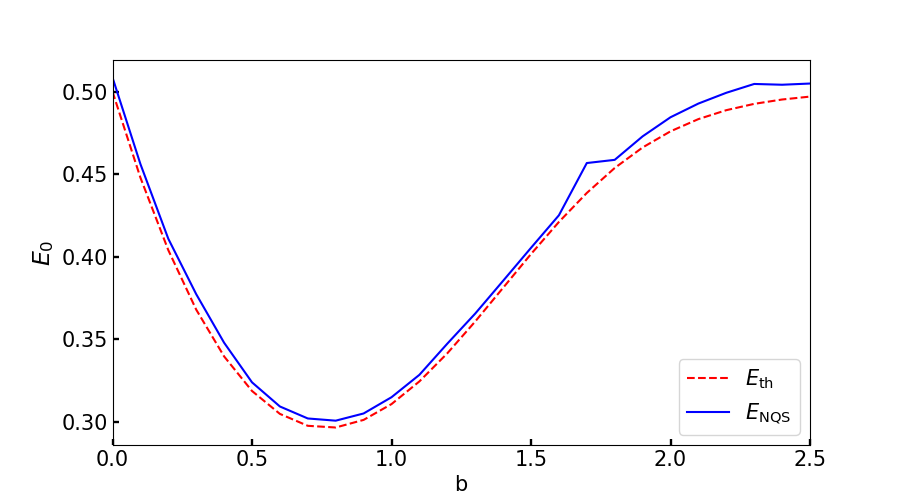

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
#ax.set_title('GS energy', fontsize=20)
ax.set_xlim(0., 2.5)
ax.set_xlabel('b', fontsize=15)
ax.set_ylabel('$E_0$', fontsize=17)
ax.plot(x_axis, E_th, linestyle='--', color='r', label='$E_\mathrm{th}$') 
ax.plot(x_axis, E_NQS, linestyle='-', color='b', label='$E_\mathrm{NQS}$') 
ax.tick_params(axis='both', labelsize=15)
ax.tick_params(axis='both', which='both', direction='in')
ax.tick_params(axis='both', which='major', width=1.7, length=4.5)
ax.legend(loc='lower right', fontsize=15)
plt.savefig('DW_E0_vs_b.pdf', format='pdf', bbox_inches='tight')

# First excited state

<IPython.core.display.Javascript object>


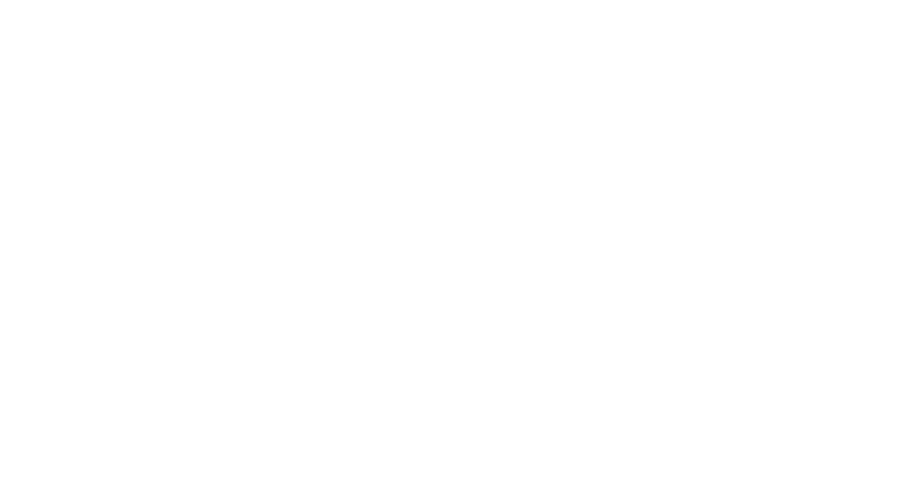

Training the NQS...: 100%|██████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1072.48it/s]


<IPython.core.display.Javascript object>


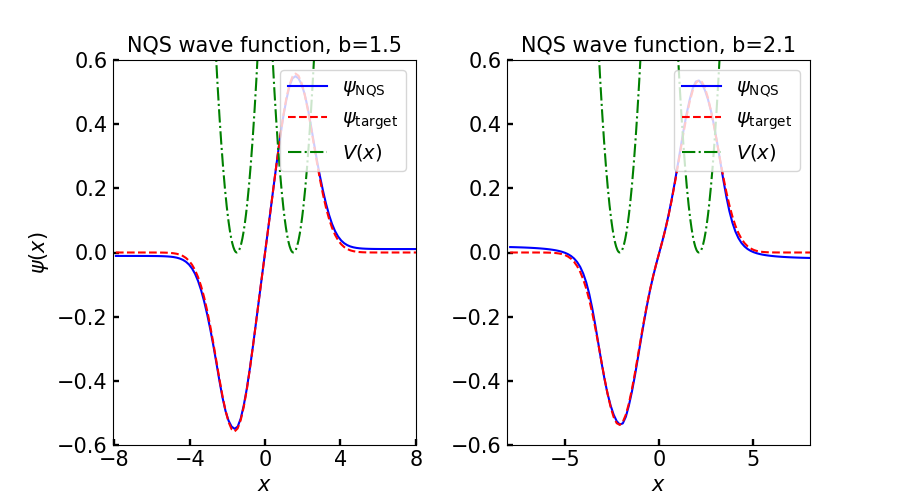

Training the NQS...: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:03<00:00, 959.75it/s]


In [38]:
psi_b1 = []
psi_b2 = []
V_b1 = []
V_b2 = []
target_b1 = []
target_b2 = []
for b in [1.5, 2.1]:
    # Imports
    import torch, time
    from torch import nn, Tensor
    from torch.autograd import grad
    import numpy as np
    import matplotlib.pyplot as plt # Plotting library
    from tqdm import tqdm # Progress bar

    # Hardware (CPU or GPU)
    dev = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(dev)

    # Network hyperparameters
    Nin = 1   # Inputs to the neural network
    Nout = 1  # Outputs of the neural network
    Nhid = 8  # Nodes in the hidden layer

    # Network parameters.
    seed = 1
    torch.manual_seed(seed)
    W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-1.) # First set of coefficients
    B = torch.rand(Nhid, requires_grad=True) * 2. - 1.    # Set of bias parameters
    W2 = torch.rand(Nout, Nhid, requires_grad=True)        # Second set of coefficients

    # Training hyperparameters
    epochs = 3000
    lr = 2e-2  # Learning rate

    # Mesh parameters
    Nx = 100                    # Mesh division
    train_a = -8                     # Mesh lower limit
    train_b = 8                        # Mesh upper limit
    h = (train_b - train_a) / (Nx - 1)  # Mesh parameter "h"
    grid = h*(np.arange(Nx)-Nx/2.+1)
    Q_train = torch.from_numpy(grid).requires_grad_().to(device).type(torch.float32)
    wi = torch.empty(Nx, 1).fill_(h)

    %matplotlib notebook
    # We define useful functions
    l_indices = [l for l in range(-int(Nx/2), int(Nx/2) + 1)]
    V = lambda x : 0.5*(abs(x)-b)**2
    delta = lambda i, j : 1 if i == j else 0
    pi = np.pi
    T = lambda l : 2.*(l*pi/(Nx*h))**2
    zi = complex(0., 1.) # imaginary unit

    # We construct the Hamiltonian matrix elements
    H = np.zeros((Nx, Nx))
    for i, xi in enumerate(grid):
        for j, xj in enumerate(grid):
            list_ = [T(l)*np.exp(zi*l*2.*pi*(i-j)/Nx) for l in l_indices]
            H[i][j] = (1/Nx)*np.real(np.sum(list_)) + V(xi)*delta(i, j)

    # We diagonalize H and obtain the ground-state eigenvalue and eigenvector
    eivals, eivecs = np.linalg.eigh(H)

    # We sort the eigenvalues and eigenvectors
    isort = np.argsort(eivals)
    eivals = eivals[isort]
    eivecs = eivecs[isort]

    ieig = 0
    neig = 4
    indx_origin = int(Nx/2 - 1)
    wf = np.zeros((Nx, neig))

    # We order the wavefunction values by setting the correct origin
    while ieig < neig :
        # wavefunction at the origin
        wf_at_origin = eivecs[indx_origin,ieig]
        sss = eivecs[indx_origin+2,ieig]
        sss = sss/np.abs(sss)
        wf[:,ieig] = sss*eivecs[:,ieig]/np.sqrt(h);
        ieig = ieig+1

    E0_th, psi0_th = eivals[0], wf[:,0]/np.sqrt(h*np.sum(wf[:,0]**2))
    E1_th, psi1_th = eivals[1], wf[:,1]/np.sqrt(h*np.sum(wf[:,1]**2))

    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
    for i in range(neig):
        ax.plot(grid, wf[:, i], label=f'$\psi_{i}$, E=' + format(eivals[i], '.4f'))
    ax.legend()
    fig.canvas.draw()
    time.sleep(0.01)
    """
    
    class HarmonicNQS(nn.Module):
        def __init__(self, W1, B, W2):
            super(HarmonicNQS, self).__init__()

            # We set the operators 
            self.lc1 = nn.Linear(in_features=Nin, 
                                 out_features=Nhid, 
                                 bias=True)   # shape = (Nhid, Nin)
            self.actfun = nn.Sigmoid()        # activation function
            self.lc2 = nn.Linear(in_features=Nhid, 
                                 out_features=Nout, 
                                 bias=False)  # shape = (Nout, Nhid)

            # We set the parameters 
            with torch.no_grad():
                self.lc1.weight = nn.Parameter(W1)
                self.lc1.bias = nn.Parameter(B)
                self.lc2.weight = nn.Parameter(W2)

        # We set the architecture
        def forward(self, x): 
            o = self.lc2(self.actfun(self.lc1(x)))
            return o

    net = HarmonicNQS(W1, B, W2).to(device)
    #print("NN architecture:\n", net)

    optimizer = torch.optim.RMSprop(params=net.parameters(), lr=lr)
    
    def pic(i, x, psi_b1, psi_b2, V_b1, V_b2, target_b1, target_b2, ax1, ax3):  
        
        # First b
        ax1.set_title('NQS wave function, b=1.5', fontsize=15)
        wf = psi_b1.detach().numpy()
        wf *= -1.
        if ax1.lines:
            # This will run every time the function is called except the first one
            ax1.lines[0].set_xdata(x.detach().numpy())
            ax1.lines[0].set_ydata(wf)
            ax1.lines[1].set_xdata(x.detach().numpy())
            ax1.lines[1].set_ydata(target_b1)
            ax1.lines[2].set_xdata(np.linspace(train_a, train_b, 500))
            ax1.lines[2].set_ydata(V_b1)
        else:
            # This code will only run the first time the function is called
            ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NQS}$', color='b')
            ax1.plot(x.detach().numpy(), target_b1, linestyle="--", 
                     label='$\psi_\mathrm{target}$', color='r')
            ax1.plot(np.linspace(train_a, train_b, 500), V_b1, linestyle='-.',
                     label='$V(x)$', color='g')
            ax1.legend(loc='upper right', fontsize=14)

        # Second b
        ax3.set_title('NQS wave function, b=2.1', fontsize=15)
        wf = psi_b2.detach().numpy()
        maxwf = np.max(wf)
        wf *= -1.
        if ax3.lines:
            # This will run every time the function is called except the first one
            ax3.lines[0].set_xdata(x.detach().numpy())
            ax3.lines[0].set_ydata(wf)
            ax3.lines[1].set_xdata(x.detach().numpy())
            ax3.lines[1].set_ydata(target_b2)
            ax3.lines[2].set_xdata(np.linspace(train_a, train_b, 500))
            ax3.lines[2].set_ydata(V_b2)
        else:
            # This code will only run the first time the function is called
            ax3.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NQS}$', color='b')
            ax3.plot(x.detach().numpy(), target_b2, linestyle="--", 
                     label='$\psi_\mathrm{target}$', color='r')
            ax3.plot(np.linspace(train_a, train_b, 500), V_b2, linestyle='-.',
                     label='$V(x)$', color='g')
            ax3.legend(loc='upper right', fontsize=14)

        fig.canvas.draw()

    def loss_fn():  
        psi = net(X)-net(-X)
        psi2 = psi.pow(2)
        dpsi_dx, = grad(outputs=psi, 
                        inputs=X,
                        grad_outputs=torch.ones_like(psi), 
                        create_graph=True)            

        N = torch.tensordot(psi2, wi)                       
        U =  (1/2) * torch.tensordot((torch.abs(X_det)-b).pow(2) * psi2, wi) / N # Potential energy
        K = (1/2) * torch.tensordot(dpsi_dx.pow(2), wi) / N # Kinetic energy
        E = U + K # Total energy

        return E, U, K, psi, psi / torch.sqrt(N) 
    
    # Plotting
    %matplotlib notebook
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
    ax1, ax3 = ax[0], ax[1]
    plt.subplots_adjust(wspace=0.3)

    # Overlap
    ax1.set_xlim(-8.1, 8)
    ax1.set_ylim(-0.6, 0.6)
    ax1.set_xlabel("$x$", fontsize=15)
    ax1.set_ylabel("$\psi(x)$", fontsize=15)
    ax1.set_xticks(np.arange(-8, 8.01, step=4))
    ax1.tick_params(axis='both', labelsize=15)
    ax1.tick_params(axis='both', which='both', direction='in')
    ax1.tick_params(axis='both', which='major', width=1.7, length=4.5)

    # Loss
    ax3.set_xlabel("$x$", fontsize=15)
    ax3.tick_params(axis='both', labelsize=15)
    ax3.tick_params(axis='both', which='both', direction='in')
    ax3.tick_params(axis='both', which='major', width=1.7, length=4.5)
    ax3.set_xlim(-8.1, 8)
    ax3.set_ylim(-0.6, 0.6)

    X = Q_train.clone().unsqueeze(1)
    X_det = X.clone().detach()
    target = psi1_th
    potential = lambda x : 0.5*(np.abs(x)-b)**2
    potential = potential(np.linspace(train_a, train_b, 500))
    
    loss_accum = []
    U_accum = []
    K_accum = []

    # Training
    for i in tqdm(range(epochs), desc="Training the NQS..."):
        loss0, U, K, psi, psi_normalized = loss_fn()    # Energy and \psi calculation

        optimizer.zero_grad() # initialize gradients to zero at each epoch
        loss0.backward()       # computation of the gradients
        optimizer.step()      # update of the parameters

        loss_accum.append(loss0.item())
        U_accum.append(U.item())
        K_accum.append(K.item())

        if (i == epochs - 1) : # We plot periodically
            if b == 1.5:
                psi_b1 = psi_normalized.clone().detach()
                V_b1 = potential
                target_b1 = target
            elif b == 2.1:
                psi_b2 = psi_normalized.clone().detach()
                V_b2 = potential
                target_b2 = target
                pic(i, Q_train, psi_b1, psi_b2, V_b1, V_b2, target_b1, target_b2, ax1, ax3)
                time.sleep(0.01)
                plt.savefig('DW_training_excited.pdf', format='pdf', bbox_inches='tight')